# Tree Based Methods
Random forest and adaboost.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns

In [2]:
from sklearn.tree import DecisionTreeClassifier

In [3]:
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
alldata = pd.read_csv('/home/wangmk/UM/Research/SURE/cleaned_data/full_cleaned_data.csv')
alldata['Agree'] = ~(alldata['True_state']^alldata['Alert'])

In [5]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
Trial                 4000 non-null int64
True_state            4000 non-null bool
Alert                 4000 non-null bool
Identification        4000 non-null bool
First_toggle_time     4000 non-null int64
RMS                   4000 non-null float64
Attention             4000 non-null float64
Click                 4000 non-null int64
Top_Left_Enemy        4000 non-null bool
Top_Right_Enemy       4000 non-null bool
Bottom_Left_Enemy     4000 non-null bool
Bottom_Right_Enemy    4000 non-null bool
Top_Left_Dark         4000 non-null bool
Top_Right_Dark        4000 non-null bool
Bottom_Left_Dark      4000 non-null bool
Bottom_Right_Dark     4000 non-null bool
Agree                 4000 non-null bool
dtypes: bool(12), float64(2), int64(3)
memory usage: 203.2 KB


In [6]:
abnormal = alldata[alldata['RMS']>60]
normal = alldata[alldata['RMS']<=60]

In [11]:
accuracy = []
precision = []
recall = []
auc = []
importance = pd.DataFrame(columns = alldata.drop(['RMS'],axis=1).columns)

In [12]:
for seed in range(10):
    print(seed)
    newdata = abnormal.append(normal.sample(n=160,random_state=seed))
    newdata['performance'] = newdata['RMS'] <= 60
    newdata['First_toggle_time'] = newdata['First_toggle_time']/10000
    newdata['Trial'] = newdata['Trial']/100
    X = newdata.drop(['RMS','performance'],axis=1)
    y = newdata['performance']
    for state in np.arange(20,30):
        print(state)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=state,stratify=y)
        rf = RandomForestClassifier()
        searcher = GridSearchCV(rf, {'n_estimators':[10,30,50,100,200],'max_features':[3,4,5,6]})
        searcher.fit(X_train, y_train)
        importance.loc[str(seed)+str(state),] = searcher.best_estimator_.feature_importances_
        y_pred = searcher.predict(X_test)
        outcome = pd.DataFrame({'Real':y_test, 'Predicted':y_pred})
        precision.append(np.sum(outcome['Real'] & outcome['Predicted'])/np.sum(outcome['Predicted']))
        recall.append(np.sum(outcome['Real'] & outcome['Predicted'])/np.sum(outcome['Real']))
        accuracy.append(np.sum(y_pred==y_test)/len(y_pred))
        y_pred_prob = searcher.predict_proba(X_test)[:,1]
        auc.append(roc(y_test,y_pred_prob))

0
20
21
22
23
24
25
26
27
28
29
1
20
21
22
23
24
25
26
27
28
29
2
20
21
22
23
24
25
26
27
28
29
3
20
21
22
23
24
25
26
27
28
29
4
20
21
22
23
24
25
26
27
28
29
5
20
21
22
23
24
25
26
27
28
29
6
20
21
22
23
24
25
26
27
28
29
7
20
21
22
23
24
25
26
27
28
29
8
20
21
22
23
24
25
26
27
28
29
9
20
21
22
23
24
25
26
27
28
29


In [33]:
conclusion = pd.DataFrame(importance.apply(np.mean),columns=['Importance'])

In [30]:
import pickle

In [31]:
outcome = {'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc}
with open('outcome_rf.pkl','wb+') as f:
    pickle.dump(outcome,f)

In [34]:
conclusion.sort_values('Importance')

,Importance
Bottom_Right_Enemy,0.006812
Top_Right_Enemy,0.008848
Bottom_Left_Enemy,0.009383
Top_Left_Enemy,0.009985
Identification,0.013108
True_state,0.014312
Agree,0.021016
Alert,0.021695
Bottom_Right_Dark,0.024321
Top_Right_Dark,0.025292


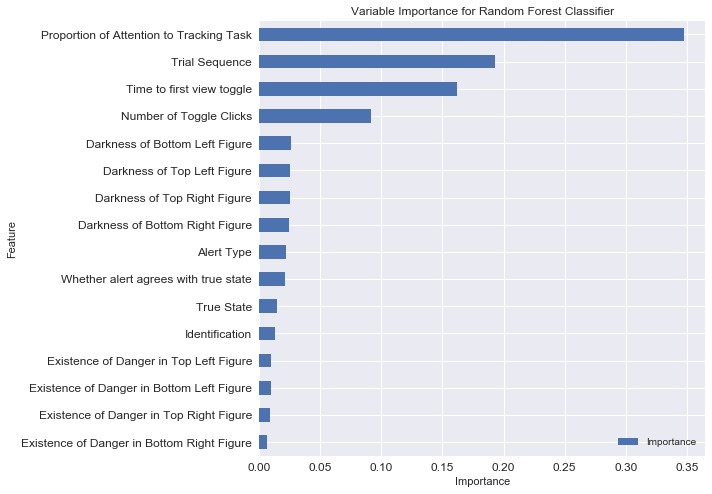

In [50]:
plt.tight_layout()
# create dataframe with top 10 by variable importance
df= conclusion.sort_values(by = 'Importance', ascending = True)
labs = ['Proportion of Attention to Tracking Task','Trial Sequence','Time to first view toggle','Number of Toggle Clicks'
        ,'Darkness of Bottom Left Figure','Darkness of Top Left Figure','Darkness of Top Right Figure','Darkness of Bottom Right Figure'
        ,"Alert Type","Whether alert agrees with true state","True State","Identification","Existence of Danger in Top Left Figure"
        ,"Existence of Danger in Bottom Left Figure","Existence of Danger in Top Right Figure","Existence of Danger in Bottom Right Figure"]
labs.reverse()
# plot
fig = plt.figure()
df.plot.barh(fontsize = 12,figsize = (8,8)).set_yticklabels(labs, rotation=0)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Variable Importance for Random Forest Classifier')
plt.savefig("VarImpPlot.png",bbox_inches='tight')

In [32]:
importance.to_csv('/home/wangmk/UM/Research/SURE/cleaned_data/importance_rf.csv')